In [2]:
import os
import numpy as np
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Paths for dataset folders
input_dataset = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images"
output_dataset = "/kaggle/working/dataset2"

# Ensure the output dataset directory exists
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)  # Remove old dataset if it exists
os.makedirs(output_dataset)

# Define basic augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Required class names
required_classes = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

# Process each class folder
for class_name in tqdm(required_classes, desc="Processing Classes"):
    class_path = os.path.join(input_dataset, class_name)
    
    if not os.path.exists(class_path):
        print(f"❌ Skipping {class_name}, folder not found.")
        continue
    
    # Create the new output class folder
    output_class_path = os.path.join(output_dataset, class_name)
    os.makedirs(output_class_path, exist_ok=True)
    
    # Load all images from the class folder
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    
    # Generate exactly 1000 augmented images
    num_images_generated = 0
    image_index = 0
    
    with tqdm(total=1000, desc=f"Augmenting {class_name}", leave=False) as pbar:
        while num_images_generated < 1000:
            img_path = images[image_index % len(images)]  # Loop through existing images
            img = load_img(img_path)  # Load image
            img = img.resize((100, 100))  # Resize to 100x100
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions
            
            # Generate augmented images
            aug_iter = datagen.flow(img_array, batch_size=1)
            for _ in range(min(1000 - num_images_generated, 5)):  # Generate up to 5 images per iteration
                augmented_img = array_to_img(next(aug_iter)[0])  # Convert back to image
                augmented_img = augmented_img.resize((100, 100))  # Resize again to ensure size
                save_path = os.path.join(output_class_path, f"aug_{num_images_generated}.png")
                augmented_img.save(save_path)  # Save image
                num_images_generated += 1
                pbar.update(1)  # Update progress bar
            
            image_index += 1  # Move to the next image

print("✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Processing Classes: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]     

✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.


In [3]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def preprocess_and_save_with_subclasses2(input_dir, output_dir, target_size=(224, 224)):
    """
    Preprocess images from input directory (with subclasses) and save to output directory.
    - Maintains the original folder structure (subclasses).
    - Applies image preprocessing: grayscale, CLAHE, Gaussian blur, Canny edge detection, and overlays edges in red.
    """
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    list1=os.listdir(input_dir)

    for subclass in list1:
        subclass_path = os.path.join(input_dir, subclass)
        if not os.path.isdir(subclass_path):
            continue  # Skip files, only process folders
        
        # Create corresponding subclass folder in the output directory
        output_subclass_path = os.path.join(output_dir, subclass)
        if not os.path.exists(output_subclass_path):
            os.makedirs(output_subclass_path)
        
        # Process each image in the subclass folder
        for image_name in tqdm(os.listdir(subclass_path), desc=f"Processing {subclass}"):
            image_path = os.path.join(subclass_path, image_name)
            image = cv2.imread(image_path)
            
            if image is None:
                continue  # Skip invalid files
            
            # Resize image
            image = cv2.resize(image, target_size)
            
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Apply CLAHE for contrast enhancement
            clahe_enhanced = clahe.apply(gray)
            
            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)
            
            # Apply Canny edge detection
            edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
            
            # Create an RGB edge map (edges in red)
            edges_colored = np.zeros_like(image)  # Create a black RGB image
            edges_colored[:, :, 2] = edges  # Set red channel to edges
            
            # Overlay the edges onto the original image
            combined = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)
            
            # Save the processed image to the corresponding output folder
            output_path = os.path.join(output_subclass_path, image_name)
            cv2.imwrite(output_path, combined)


In [4]:
# Define input and output directories
input_directory = '/kaggle/working/dataset2'  # Contains subclass folders
output_directory = '/kaggle/working/dataset6'  # Preprocessed images will be saved here

# Run preprocessing
preprocess_and_save_with_subclasses2(input_directory, output_directory)


Processing Mild: 100%|██████████| 1000/1000 [00:04<00:00, 239.30it/s]


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2 
import os
import random

In [6]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(224, 224)): 
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0
            
            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)
                    # Get image dimensions
                    (h, w) = image.shape[:2]
                    
                    # Step 1: Apply random rotation between 0 to 5 degrees
                    angle = random.uniform(0, 5)  # Random angle between 0 and 5 degrees
                    center = (w // 2, h // 2)  # Center of the image
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # Rotation matrix
                    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
                    
                    # Step 2: Apply right-to-left flip
                    image = cv2.flip(rotated_image, 1)  # Flip horizontally
                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "/kaggle/working/dataset6"
dataset, labels = load_dataset(dataset_path) 

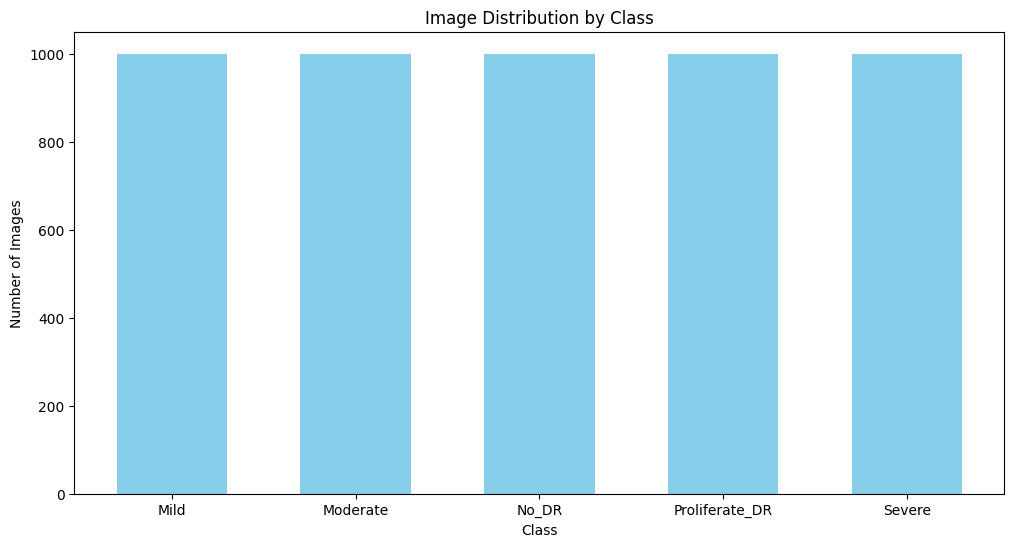

In [7]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6)) 
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)  

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

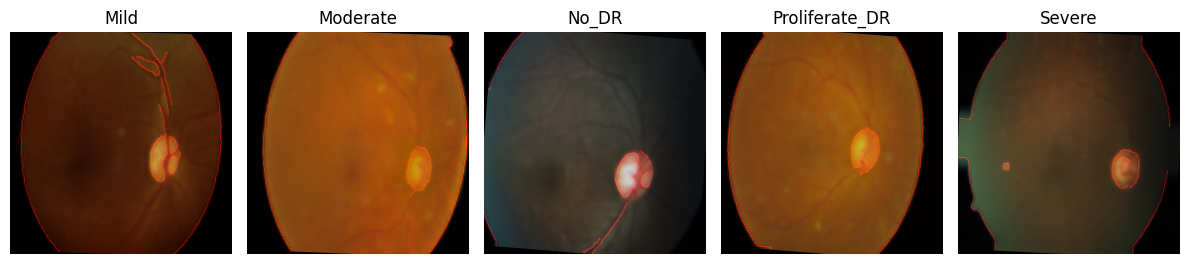

In [8]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))
    
    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



X_train, X_temp, y_train, y_temp = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224))
    
    normalized_image = resized_image / 255.0
    return normalized_image


X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])
X_val = np.array([preprocess_image(image) for image in X_val])


print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4000, 224, 224, 3)
Shape of X_val: (500, 224, 224, 3)
Shape of X_test: (500, 224, 224, 3)
Shape of y_train: (4000,)
Shape of y_val: (500,)
Shape of y_test: (500,)


In [10]:
!pip install efficientnet

  Obtaining dependency information for efficientnet from https://files.pythonhosted.org/packages/53/97/84f88e581d6ac86dcf1ab347c497c4c568c38784e3a2bd659b96912ab793/efficientnet-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for keras-applications<=1.0.8,>=1.0.7 from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [17]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Define the number of classes
num_classes = len(np.unique(labels))

# Load MobileNet without the top classification layers
mobilenet_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Create a new model
inputs = mobilenet_model.input

# Get the output of the last convolutional layer for Grad-CAM
conv_output = mobilenet_model.layers[-1].output

# Add a Global Average Pooling layer
x = GlobalAveragePooling2D()(conv_output)

# Add dense layers on top
x = Dense(128, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(64, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization(renorm=True)(x)
x = Dropout(0.3)(x)

# Final classification layer
outputs = Dense(units=num_classes, activation='softmax')(x)

# Combine into the model
model = models.Model(inputs=inputs, outputs=outputs)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Compile the model
custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/50
125/125 [==============================] - 23s 89ms/step - loss: 2.1988 - accuracy: 0.3957 - val_loss: 2.0305 - val_accuracy: 0.3840
Epoch 2/50
125/125 [==============================] - 10s 76ms/step - loss: 1.8170 - accuracy: 0.5418 - val_loss: 1.6870 - val_accuracy: 0.5680
Epoch 3/50
125/125 [==============================] - 10s 77ms/step - loss: 1.6213 - accuracy: 0.5980 - val_loss: 1.4422 - val_accuracy: 0.6560
Epoch 4/50
125/125 [==============================] - 10s 77ms/step - loss: 1.4691 - accuracy: 0.6628 - val_loss: 1.3441 - val_accuracy: 0.7080
Epoch 5/50
125/125 [==============================] - 10s 76ms/step - loss: 1.2630 - accuracy: 0.7467 - val_loss: 1.2127 - val_accuracy: 0.7700
Epoch 6/50
125/125 [==============================] - 10s 76ms/step - loss: 1.1329 - accuracy: 0.7990 - val_loss: 1.1576 - val_accuracy: 0.7740
Epoch 7/50
125/125 [==============================] - 10s 76ms/step - l

In [18]:
# Save the weights of the model to a file
model.save_weights('efficientnet_diabetic_retinopathy_disease.h5')

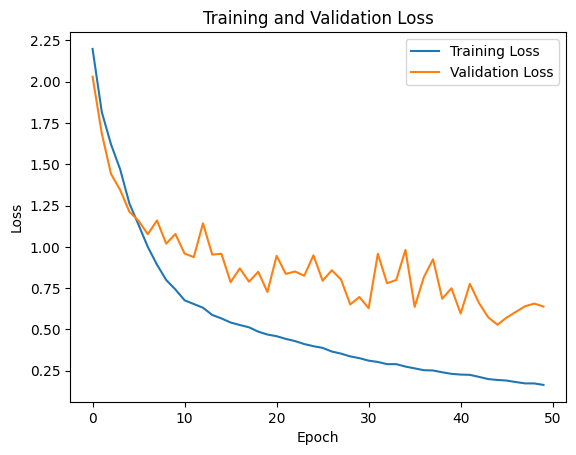

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

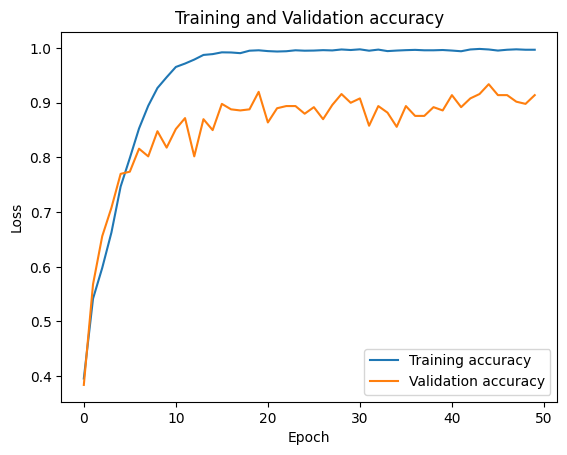

In [20]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 1s 26ms/step
Test Accuracy: 0.9340


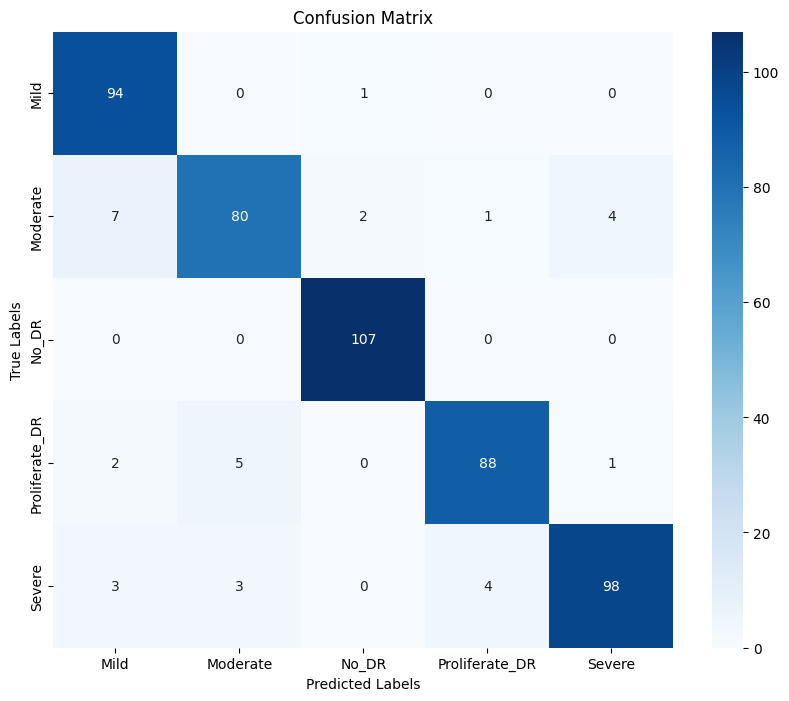

Classification Report:
                precision    recall  f1-score   support

          Mild     0.8868    0.9895    0.9353        95
      Moderate     0.9091    0.8511    0.8791        94
         No_DR     0.9727    1.0000    0.9862       107
Proliferate_DR     0.9462    0.9167    0.9312        96
        Severe     0.9515    0.9074    0.9289       108

      accuracy                         0.9340       500
     macro avg     0.9333    0.9329    0.9321       500
  weighted avg     0.9348    0.9340    0.9335       500



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and predicted classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = y_test

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_, digits=4))


1/1 [==============================] - 0s 139ms/step


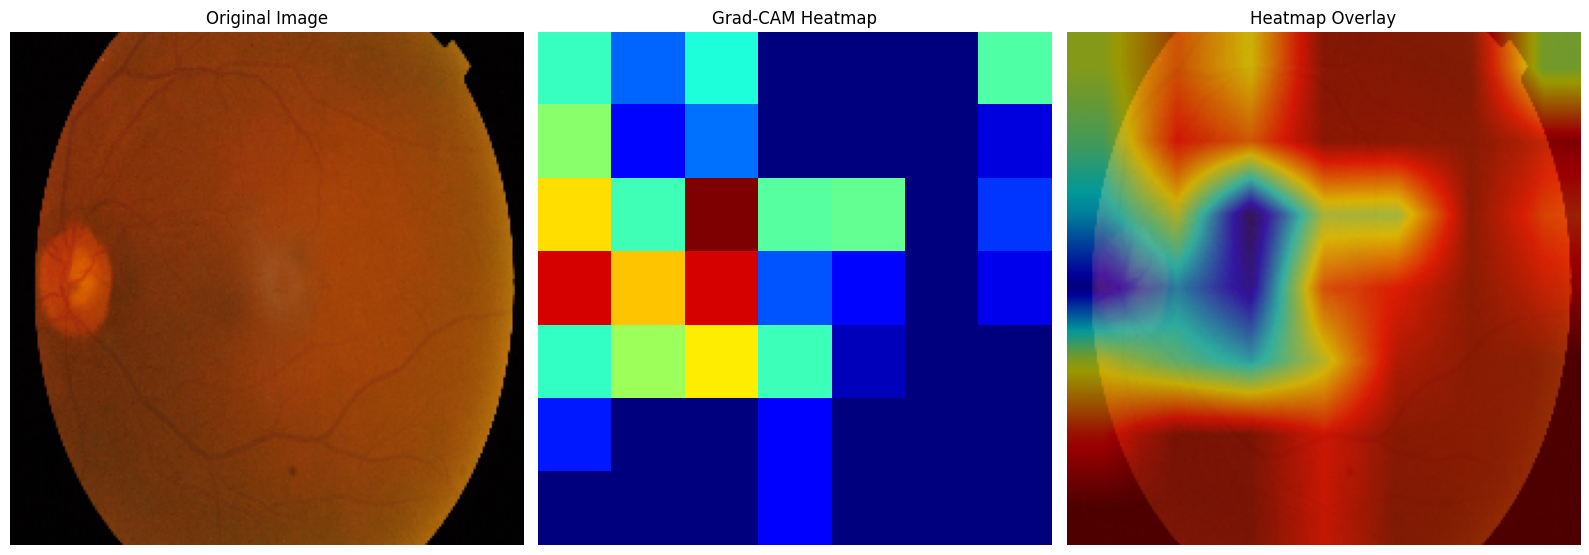

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    # Build a model that maps the input image to the activations of the last conv layer and the predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(guided_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    # Convert heatmap to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    # Overlay the heatmap on the original image
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Ask the user to provide the image path
image_path = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images/Mild/0024cdab0c1e.png"

# Load and preprocess the image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(original_image, (224, 224)) / 255.0  # Resize and normalize

# Get the predicted class index
class_idx = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# Generate the Grad-CAM heatmap
heatmap = generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name='conv_pw_13_relu')  # MobileNet's last conv layer

# Overlay the heatmap on the original image
overlayed_image = overlay_heatmap_on_image(heatmap, original_image)

# Plot the results
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Heatmap overlaid on original image
plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
